# 1번 - 노래 가사를 이용한 장르 분류

## 데이터 설명
- Country, Jazz, Pop, R&B, Rock 총 5개의 category
- 각 category마다 약 800~900개의 가사 데이터 제공
- 파일은 Song(노래제목), lyrics(가사), genre(장르)로 구성됨
- 노래 lyrics(가사) 데이터를 사용하여 genre(장르) 분류를 하고자 합니다.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

- lyrics_train.csv, lyrics_test.csv 파일을 불러오고 'lyrics'를 피처 데이터, 'genre'를 target 데이터로 정의해주세요

In [2]:
train=pd.read_excel("lyrics_train.xlsx")
test=pd.read_excel("lyrics_test.xlsx")
lyrics_train=train["lyrics"]
lyrics_test=test["lyrics"]
genre_train=train["genre"]
genre_test=test["genre"]

- TF-IDF Vectorization(파라미터 모두 디폴트로 적용) 적용하여 학습 데이터셋과 테스트 데이터 셋 변환을 수행한 뒤, LogisticRegression을 이용하여 학습/예측/평가를 수행하세요 

In [3]:
vectorizer = TfidfVectorizer(min_df = 3)
lyrics_train_fit = vectorizer.fit_transform(lyrics_train).toarray()
lyrics_test_fit = vectorizer.transform(lyrics_test).toarray()
lr_clf = LogisticRegression() 
lr_clf.fit(lyrics_train_fit, genre_train)
train_pred = lr_clf.predict(lyrics_train_fit)
print('Train Lyrics의 정확도는: {}'.format(accuracy_score(genre_train, train_pred)))
test_pred = lr_clf.predict(lyrics_test_fit)
print('Test Lyrics의 정확도는: {}'.format(accuracy_score(genre_test, test_pred)))

C:\Users\yurik\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Lyrics의 정확도는: 0.7375556026265622
Test Lyrics의 정확도는: 0.417


- pipeline, gridsearch를 사용하여 모델 최적화를 수행한 뒤, 최적의 파라미터와 예측 정확도 값을 출력해주세요
- pipeline : TfidfVectorizer 와 LogisticRegression 으로 구성
- 파라미터 후보 :<br> - TfidfVectorizer<br>
  {'ngram_range': [(1,1),(1,3)],<br> 'max_df': [100,700]} <br>- LogisticRegression<br> {'C': [1,10] }
- cv=3 , scoring='accuracy',n_jobs=-1으로 gridsearch 수행 
- 시간이 조금 오래 걸릴 수도 있기에(5~6분) 돌려놓고 밑에 코드 짜는 것을 추천드립니다


In [4]:
pipeline=Pipeline([('vectorizer',TfidfVectorizer(stop_words='english')),('lr_clf',LogisticRegression())])
params={'vectorizer__ngram_range':[(1,1),(1,3)],'vectorizer__max_df':[100,700],'lr_clf__C':[1,10]}

grid_cv_pipe=GridSearchCV(pipeline,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)
grid_cv_pipe.fit(lyrics_train, genre_train)
print(grid_cv_pipe.best_params_,grid_cv_pipe.best_score_)

{'lr_clf__C': 1, 'vectorizer__max_df': 700, 'vectorizer__ngram_range': (1, 3)} 0.39335065227406685


- (보너스 문제) 비타민에서 그 동안 배운 다양한 분류모델과 텍스트 전처리 기법, 파라미터 최적화 방법들을 자유롭게 사용하여 모델의 성능을 높여주세요
- 필수 문항 아니니 해보고 싶은 분들만 하셔도 됩니다!

# 2번 - 노래 군집화

- 이번에는 노래 가사 데이터를 활용하여 노래 군집화를 수행하고자 합니다.(1번과 데이터 동일)
- word_tokenize와 lemmatize를 순차적으로 수행하는 tokenize_and_lemmatize 함수를 만들어주세요

In [13]:
from nltk.stem import WordNetLemmatizer
import nltk
import re

lemmar=WordNetLemmatizer()
def tokenize_and_lemmatize(data):
    res = []
    punctuation = re.compile(r'[-.,?!:;()|0-9]')
    data=punctuation.sub(' ',data)
    for word in nltk.word_tokenize(data):
            res.append(lemmar.lemmatize(word.lower()))

    return res


- TF-IDF Vectorization 적용하여 학습 데이터셋(X_train)변환을 수행하세요
- TF-IDF Vectorization 파라미터 : tokenizer=tokenize_and_lemmatize, stop_words='english',ngram_range=(1,2), min_df=0.05, max_df=0.85 
- 밑에 시각화 코드와의 연동을 위해 변환된 학습 데이터셋의 이름을 X_train_tfidf_vect으로 지정해주세요

In [14]:
tfdif_vect=TfidfVectorizer(tokenizer=tokenize_and_lemmatize, stop_words='english',ngram_range=(1,2), min_df=0.05, max_df=0.85)
X_train_tfidf_vect=tfdif_vect.fit_transform(lyrics_train)

C:\Users\yurik\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


- KMeans(n_clusters=5, max_iter=1000)를 사용하여 5개 장르에 대해 군집화를 수행하고 cluster label과 center를 설정하세요
  (밑에 시각화 코드와의 연동을 위해 cluster_label, cluster_centers 이름으로 설정해주세요)

In [15]:
from sklearn.cluster import KMeans
km_cluster=KMeans(n_clusters=5,max_iter=10000)
km_cluster.fit(X_train_tfidf_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

- 군집화 수행한 결과를 pca를 사용하여 시각해보겠습니다(코드 돌려서 군집화가 잘 되었는지 확인만 해보면 됩니다)

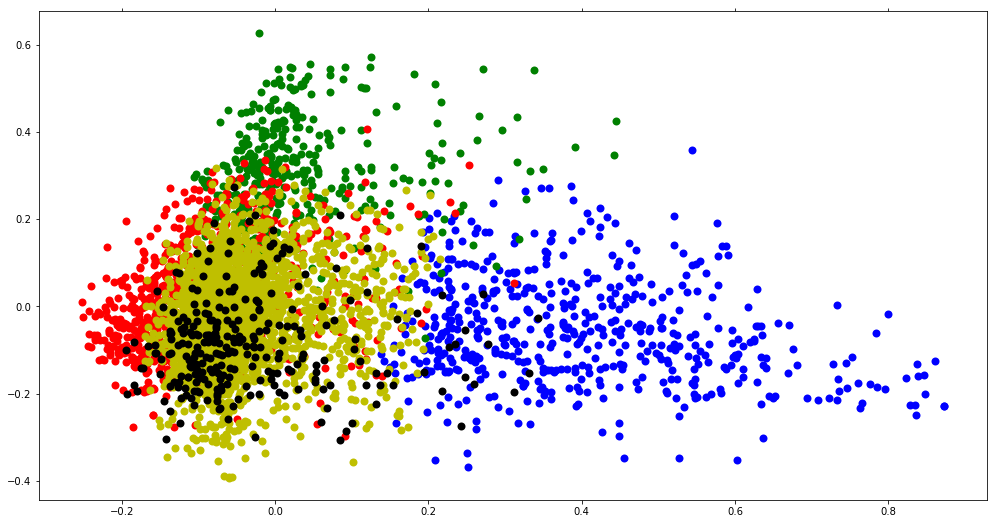

In [16]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

clusters = km_cluster.labels_.tolist()
labels = genre_train

colors = {0: 'b', 1: 'g', 2: 'r', 3: 'y', 4:'k'}

pca = PCA(n_components=2).fit_transform(X_train_tfidf_vect.toarray())
xs, ys = pca[:, 0], pca[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'y', 4:'k'}

# df = pd.DataFrame(dict(x=xs, y=ys, label=labels))
# colors = {'Country': 'b', 'Jazz': 'g', 'Pop': 'r', 'R&B': 'y', 'Rock':'k'}

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 

for idx, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            color=colors[idx], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
plt.show() 

- 위의 군집화 과정을 k=3(군집개수 3)으로 똑같이 반복하고 시각화까지 진행해주세요


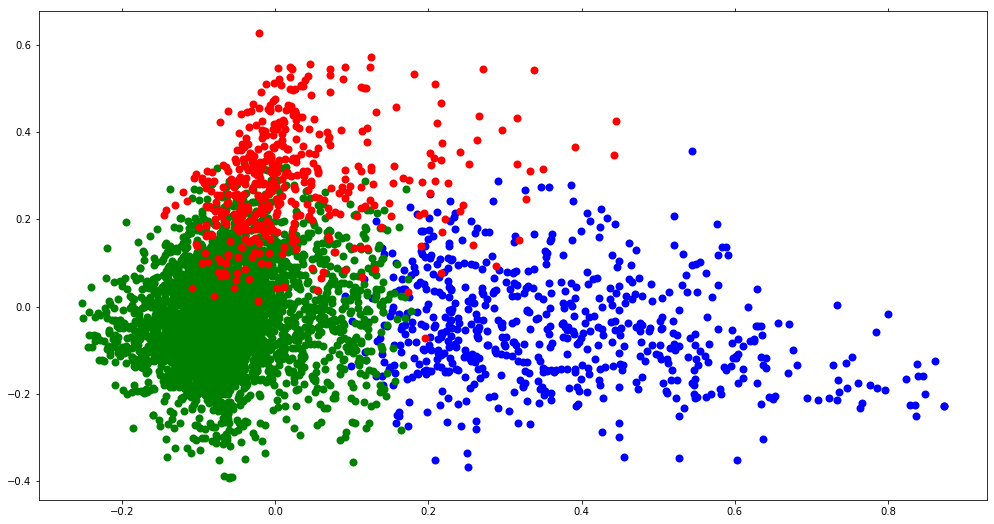

In [17]:
km_cluster=KMeans(n_clusters=3,max_iter=10000)
km_cluster.fit(X_train_tfidf_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_


clusters = km_cluster.labels_.tolist()
labels = genre_train

colors = {0: 'b', 1: 'g', 2: 'r', 3: 'y', 4:'k'}

pca = PCA(n_components=2).fit_transform(X_train_tfidf_vect.toarray())
xs, ys = pca[:, 0], pca[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'y', 4:'k'}

# df = pd.DataFrame(dict(x=xs, y=ys, label=labels))
# colors = {'Country': 'b', 'Jazz': 'g', 'Pop': 'r', 'R&B': 'y', 'Rock':'k'}

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 

for idx, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            color=colors[idx], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
plt.show() 

# 3번 - 토픽모델링

- fetch_20newsgroups 데이터를 이용하여 토픽모델링을 수행하고자 합니다
- 'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med' 4가지 카테고리에 해당하는 데이터를 불러와주세요
- 불러온 데이터에 CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))를 적용하고 CountVectorizer Shape를 출력하세요

In [18]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cats=['talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']
df = fetch_20newsgroups(subset="all", random_state=0, remove=('headers', 'footers', 'quotes'),categories=cats)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english', ngram_range=(1,2))
feat_vect=vectorizer.fit_transform(df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (3911, 1000)


- LDA모델을 학습한 후, Topic별 가장 연관도가 높은 word를 15개씩 출력해주세요

In [19]:
lda=LatentDirichletAllocation(n_components=4,random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=4, random_state=0)

In [20]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        
        topic_word_indexes=topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        feature_concat=' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)

feature_names=vectorizer.get_feature_names()
display_topics(lda,feature_names,15)

Topic 0:
god don like know does people just think good time use believe jesus way say
Topic 1:
armenian israel jews turkish people armenians jewish israeli government war arab turkey genocide turks armenia
Topic 2:
said people know didn don just went did time church like told say came going
Topic 3:
medical health 10 disease cancer information patients 1993 use research hiv number 92 12 greek
